Saving vco_dataset_triang.xlsx to vco_dataset_triang (6).xlsx
Saving vco_dataset_steps.xlsx to vco_dataset_steps (6).xlsx
Saving vco_dataset_pulse.xlsx to vco_dataset_pulse (6).xlsx
Saving vco_dataset_dc95.xlsx to vco_dataset_dc95 (6).xlsx
Saving vco_dataset_dc9.xlsx to vco_dataset_dc9 (6).xlsx
Saving vco_dataset_dc85.xlsx to vco_dataset_dc85 (6).xlsx
Saving vco_dataset_dc8.xlsx to vco_dataset_dc8 (6).xlsx
Saving vco_dataset_dc7.xlsx to vco_dataset_dc7 (6).xlsx
Saving vco_dataset_dc6.xlsx to vco_dataset_dc6 (6).xlsx
Saving vco_dataset_dc1.xlsx to vco_dataset_dc1 (6).xlsx
Saving vco_dataset_sin.xlsx to vco_dataset_sin (6).xlsx
=== Data Head ===
           time   v(net1)  v(net2)
0  0.000000e+00  0.600000      1.8
1  1.000000e-13  0.600004      1.8
2  2.000000e-13  0.600008      1.8
3  4.000000e-13  0.600016      1.8
4  8.000000e-13  0.600032      1.8

=== Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 3 columns):
 #   Column  

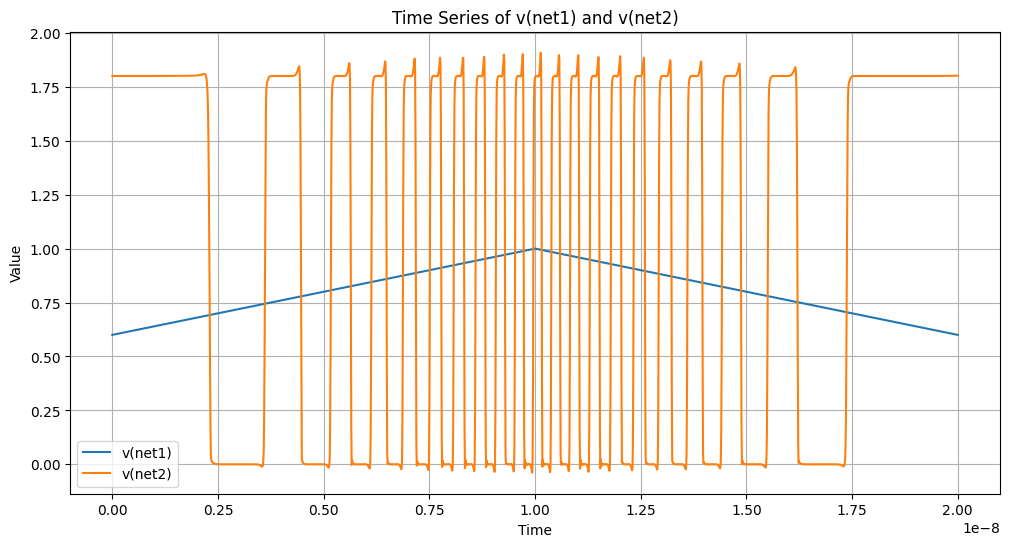

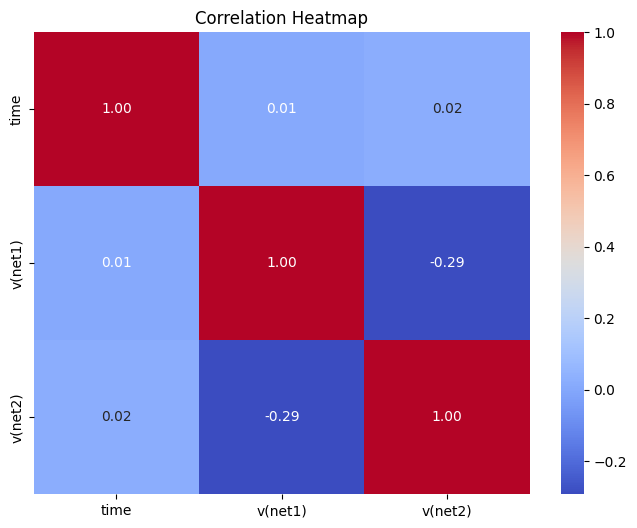

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - loss: 1.0284 - mae: 0.7843 - val_loss: 0.3954 - val_mae: 0.4843 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.4027 - mae: 0.5240 - val_loss: 0.3710 - val_mae: 0.4772 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.2968 - mae: 0.4561 - val_loss: 0.3444 - val_mae: 0.4685 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.2582 - mae: 0.4380 - val_loss: 0.2891 - val_mae: 0.4565 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.2206 - mae: 0.4147 - val_loss: 0.2601 - val_mae: 0.4457 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.2084 - mae: 0.4087 - val_loss: 0.2586 - val_mae: 0.4473 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.2053 - mae: 0.4101 - val_loss: 0.2526 - val_mae: 0.4456 - learning_rate: 0.0010
Epoc

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


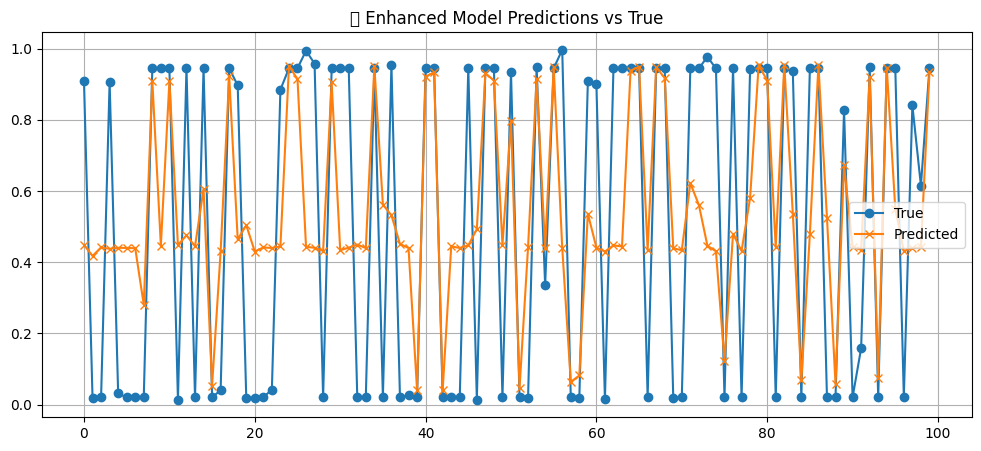

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Conv1D, GlobalAveragePooling1D, Concatenate, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from google.colab import files

# ===== Step 1: Upload and Load Data =====
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_excel(filename)
df.columns = df.columns.str.strip()

# ===== EDA: Exploratory Data Analysis =====
print("=== Data Head ===")
print(df.head())

print("\n=== Data Info ===")
print(df.info())

print("\n=== Summary Statistics ===")
print(df.describe())

print("\n=== Missing Values ===")
print(df.isna().sum())

# Plot time series of key features
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['v(net1)'], label='v(net1)')
plt.plot(df['time'], df['v(net2)'], label='v(net2)')
plt.title('Time Series of v(net1) and v(net2)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# ===== Step 2: Feature Engineering =====
df['v(net1)_delta'] = df['v(net1)'].diff().fillna(0)

# ===== Step 3: Normalize features =====
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['time', 'v(net1)', 'v(net1)_delta', 'v(net2)']])
scaled_df = pd.DataFrame(scaled, columns=['time', 'v(net1)', 'v(net1)_delta', 'v(net2)'])

# ===== Step 4: Prepare sequences =====
window_size = 10
X_seq, Y = [], []

for i in range(len(scaled_df) - window_size):
    seq = scaled_df[['time', 'v(net1)', 'v(net1)_delta']].values[i:i+window_size]
    X_seq.append(seq)
    Y.append(scaled_df['v(net2)'].values[i+window_size])

X_seq = np.array(X_seq)
Y = np.array(Y)[:, np.newaxis]

# ===== Step 5: Train-Test Split =====
X_train, X_test, Y_train, Y_test = train_test_split(X_seq, Y, test_size=0.2, random_state=42)

# ===== Step 6: Build Model (Improved RNN + FCN with stacked Bidirectional GRUs) =====
input_seq = Input(shape=(window_size, 3))

# FCN branch with Conv1D + BatchNorm + Dropout
x_fcn = Conv1D(64, 3, activation='relu', padding='same')(input_seq)
x_fcn = BatchNormalization()(x_fcn)
x_fcn = Dropout(0.3)(x_fcn)
x_fcn = Conv1D(128, 3, activation='relu', padding='same')(x_fcn)
x_fcn = BatchNormalization()(x_fcn)
x_fcn = Dropout(0.3)(x_fcn)
x_fcn = GlobalAveragePooling1D()(x_fcn)

# RNN branch with stacked Bidirectional GRUs + BatchNorm + Dropout
x_rnn = Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))(input_seq)
x_rnn = BatchNormalization()(x_rnn)
x_rnn = Bidirectional(GRU(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.1))(x_rnn)
x_rnn = BatchNormalization()(x_rnn)

# Merge branches
merged = Concatenate()([x_fcn, x_rnn])
x = Dense(128, activation='relu')(merged)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(1, activation='linear')(x)

model = Model(inputs=input_seq, outputs=output)

# Use Adam optimizer with gradient clipping to stabilize training
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# ===== Step 7: Train Model with Callbacks =====
early_stop = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

history = model.fit(
    X_train, Y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ===== Step 8: Evaluate Model =====
Y_pred = model.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)

print(f"📉 Enhanced MAE: {mae:.6f}, MSE: {mse:.6f}")

# ===== Step 9: Plot Results =====
plt.figure(figsize=(12, 5))
plt.plot(Y_test[:100], label='True', marker='o')
plt.plot(Y_pred[:100], label='Predicted', marker='x')
plt.title('📊 Enhanced Model Predictions vs True')
plt.legend()
plt.grid(True)
plt.show()
